In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Determine the effective spread using the block method `cov([dt1, dt2, dt3], [dt4, dt5, dt6])`

### Determine the effective spread using the serial covariance `cov([dt1, dt2, dt3], [dt2, dt3, dt4])`

In [2]:
data = pd.read_csv('data/aapl_5m_train.csv')
data.drop(columns=['Unnamed: 0', 'Gmtoffset', 'Datetime', 'Volume'], inplace=True)
data['Diff'] = data['Close'].diff()
data['Diff_Shift'] = data['Diff'].shift()
data = data.dropna()

windows = [5, 10, 20, 50, 100]


for window in windows:
    data[f'W_{window}'] = data['Diff'].rolling(window=window).cov(data['Diff_Shift'])

for i in range(len(windows)):
    data[f'Spread_{windows[i]}'] = 2 * np.sqrt(np.abs(data[f'W_{windows[i]}']))


bid_ask = pd.DataFrame()
for i in range(len(windows)):
    bid_ask[f'Bid_{windows[i]}'] = np.where(data['Diff'] > 0, #Si subió entonces es un ask
                                            data['Close'] - data[f'Spread_{windows[i]}'], #Restar spread convierte a bid
                                            data['Close']) #Ask
    bid_ask[f'Ask_{windows[i]}'] = np.where(data['Diff'] > 0,
                                            data['Close'], #Bid
                                            data['Close'] + data[f'Spread_{windows[i]}']) #Sumar spread convierte a ask
bid_ask.head(25)

,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997
1,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000
2,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN
3,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN
4,131.119995,131.685307,131.119995,NaN,131.119995,NaN,131.119995,NaN,131.119995,NaN
5,130.875000,131.110543,130.875000,NaN,130.875000,NaN,130.875000,NaN,130.875000,NaN
6,130.509902,130.987652,130.509902,NaN,130.509902,NaN,130.509902,NaN,130.509902,NaN
7,130.620137,130.889999,NaN,130.889999,NaN,130.889999,NaN,130.889999,NaN,130.889999
8,130.783359,130.935806,NaN,130.935806,NaN,130.935806,NaN,130.935806,NaN,130.935806
9,130.836237,131.053604,130.746168,131.053604,NaN,131.053604,NaN,131.053604,NaN,131.053604


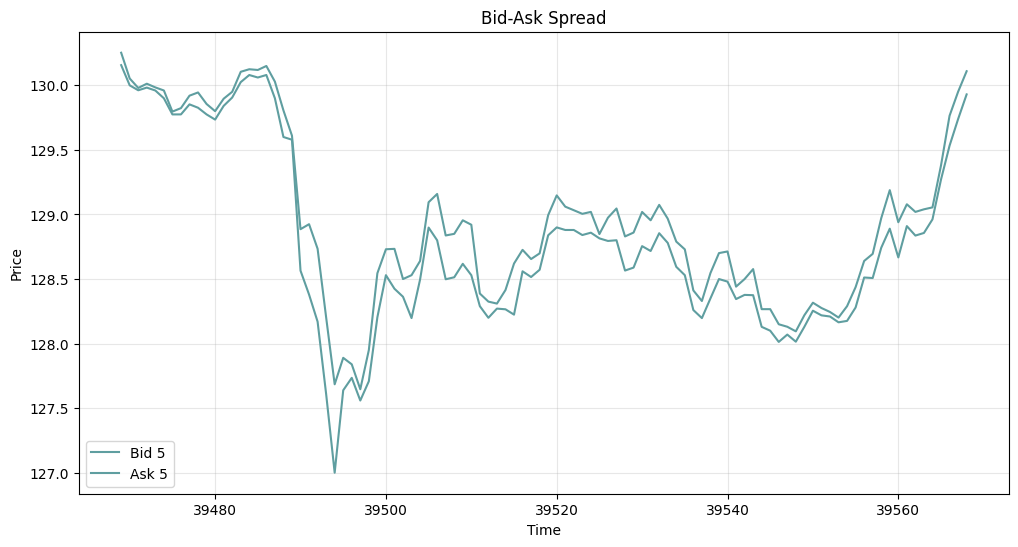

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(bid_ask['Bid_5'].tail(100), label='Bid 5', color='cadetblue')
plt.plot(bid_ask['Ask_5'].tail(100), label='Ask 5', color='cadetblue')
plt.title('Bid-Ask Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)
plt.show()